In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 훈련데이터 가져오기
df = pd.read_excel('data/wiset_single_sensor_model_train_data_3.xlsx')

In [2]:
# 원점(2번센서)으로부터의 거리 계산
def calculate_distance(x,y):
    return np.sqrt(x**2 + y**2)


In [3]:
df['distance'] = calculate_distance(df['x'],df['y'])

X = df[['azimuth', 'elevation', 'x', 'y', 'new_illum_11', 'distance']].values
y = df['illum'].values

# 훈련 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 파이토치 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
# Define model
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2) # 드롭아웃
        self.fc5 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x


input_shape = X_train.shape[1]
model = NeuralNet(input_shape)


In [5]:
# 손실함수 및 옵티마이저 설정
criterion = nn.L1Loss() # L1 loss가 MAE임
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# 조기종료 적용하여 훈련
num_epochs = 100
patience = 20 # 20 에포크 이상 손실 줄지 않으면 훈련 종료
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping")
        break

    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    # 조기종료
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True


Epoch [1/100], Train Loss: 23.3881, Test Loss: 13.8001
Epoch [2/100], Train Loss: 20.1987, Test Loss: 12.6534
Epoch [3/100], Train Loss: 19.1135, Test Loss: 13.4392
Epoch [4/100], Train Loss: 18.5410, Test Loss: 12.4011
Epoch [5/100], Train Loss: 18.2368, Test Loss: 13.2457
Epoch [6/100], Train Loss: 17.7617, Test Loss: 11.2626
Epoch [7/100], Train Loss: 17.4686, Test Loss: 10.9091
Epoch [8/100], Train Loss: 17.3536, Test Loss: 11.4652
Epoch [9/100], Train Loss: 17.1025, Test Loss: 12.5875
Epoch [10/100], Train Loss: 16.8913, Test Loss: 11.0760
Epoch [11/100], Train Loss: 16.9078, Test Loss: 10.5604
Epoch [12/100], Train Loss: 16.8084, Test Loss: 11.2068
Epoch [13/100], Train Loss: 16.6236, Test Loss: 13.7867
Epoch [14/100], Train Loss: 16.5439, Test Loss: 10.9064
Epoch [15/100], Train Loss: 16.4472, Test Loss: 12.7468
Epoch [16/100], Train Loss: 16.4541, Test Loss: 11.0331
Epoch [17/100], Train Loss: 16.3551, Test Loss: 10.2551
Epoch [18/100], Train Loss: 16.2519, Test Loss: 12.3119
E

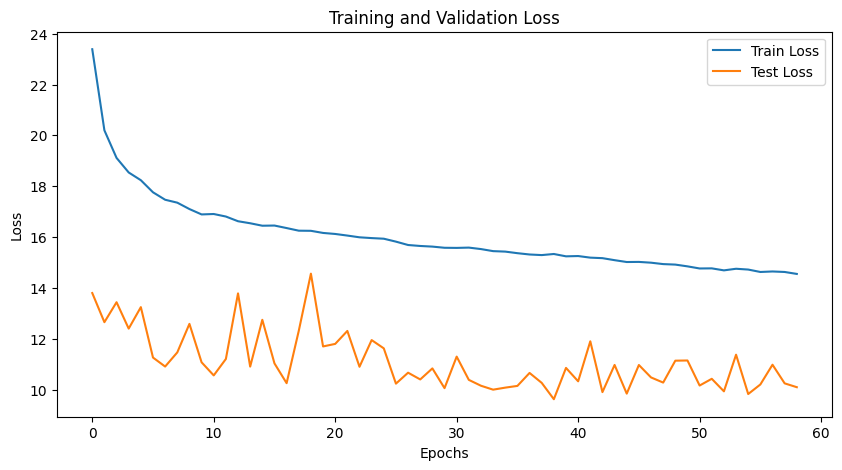

In [7]:
# 손실값 그래프
plt.figure(figsize=(10,5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


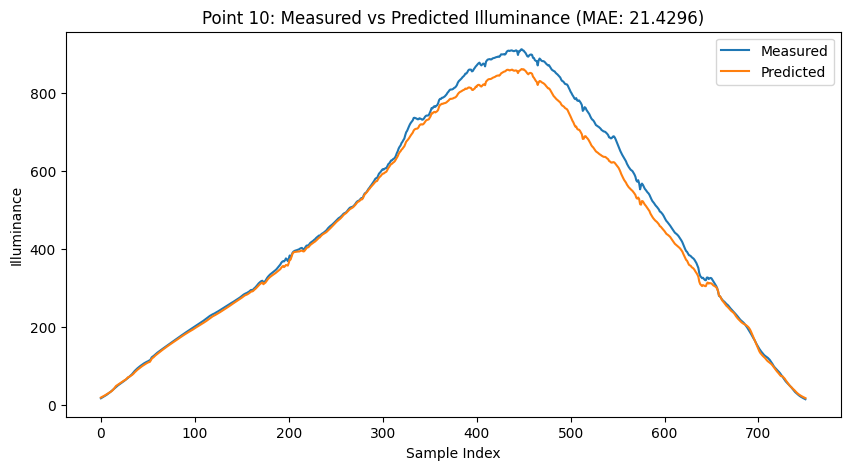

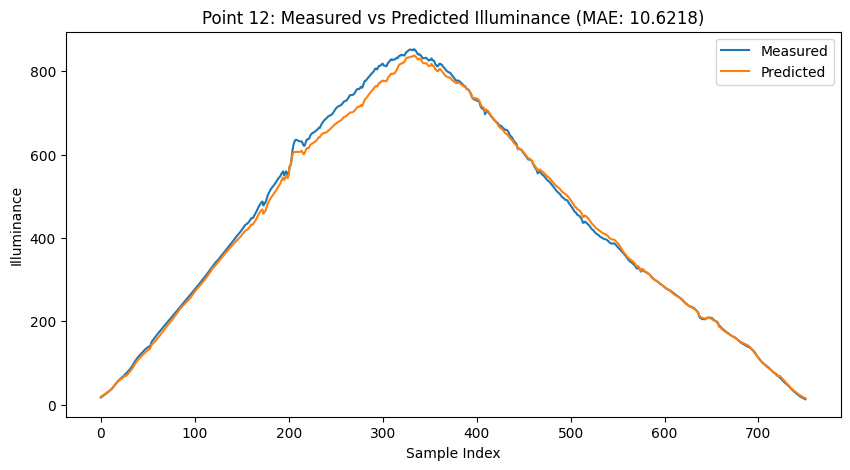

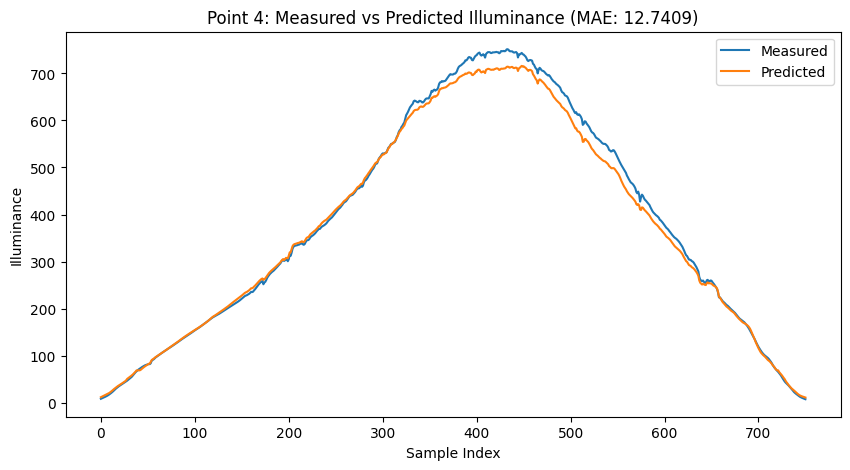

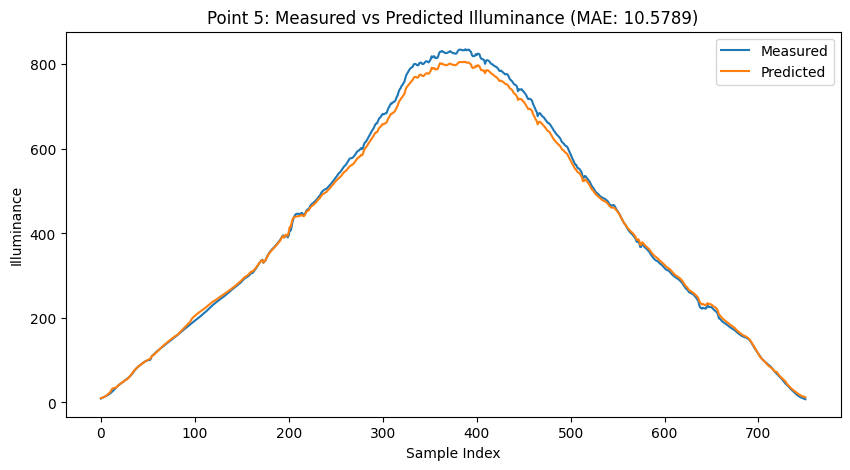

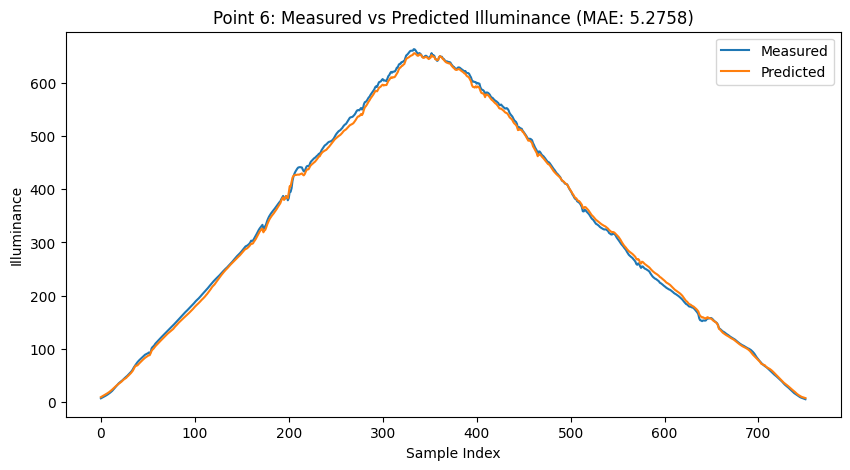

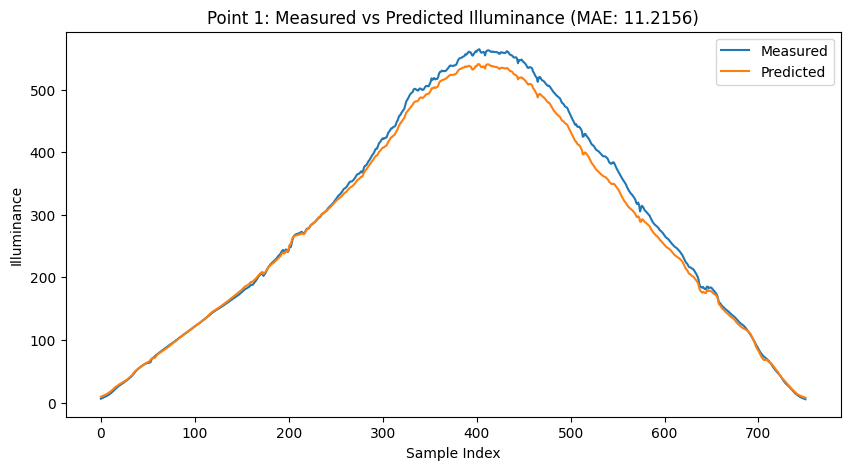

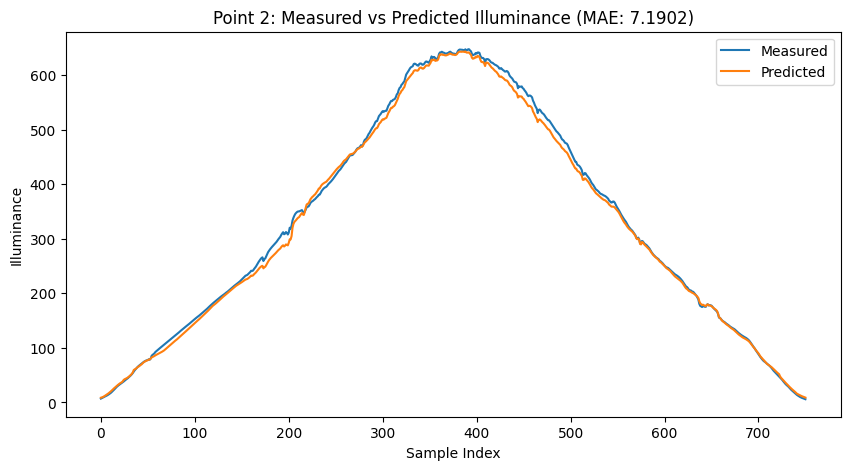

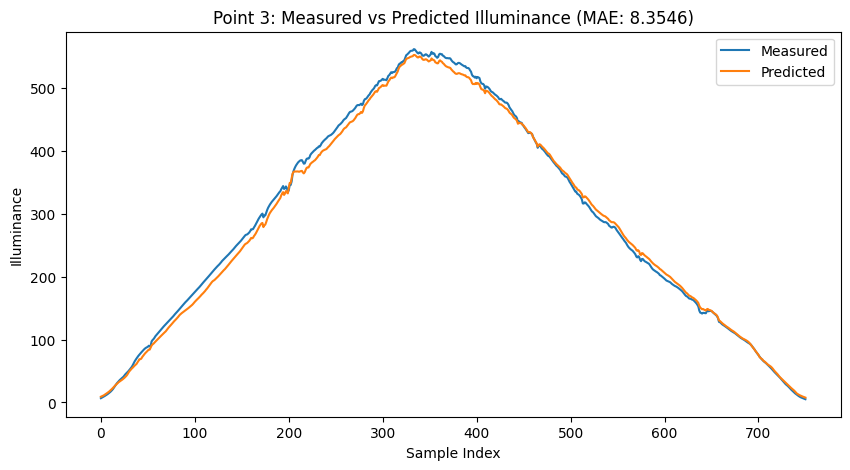

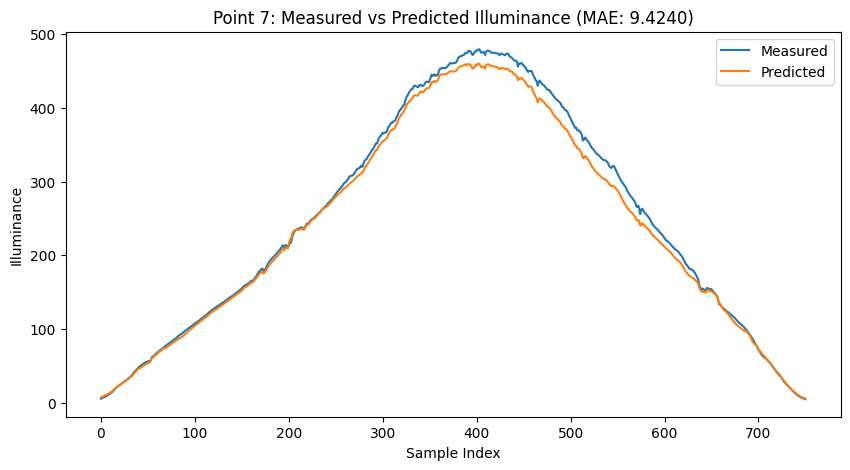

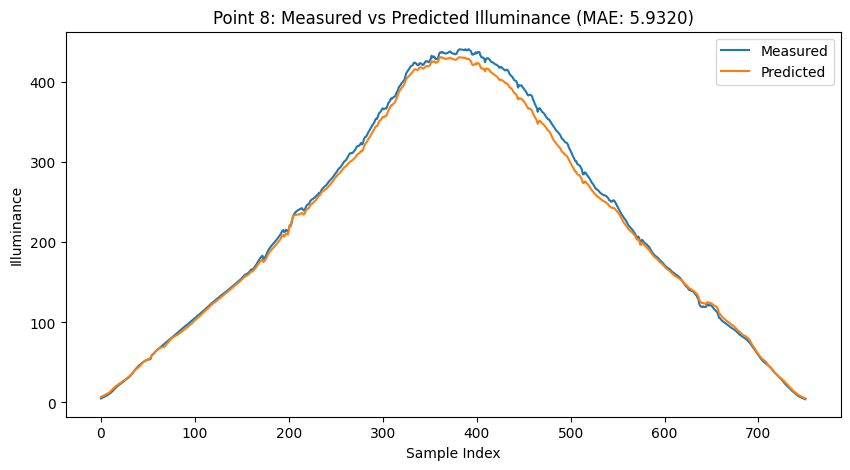

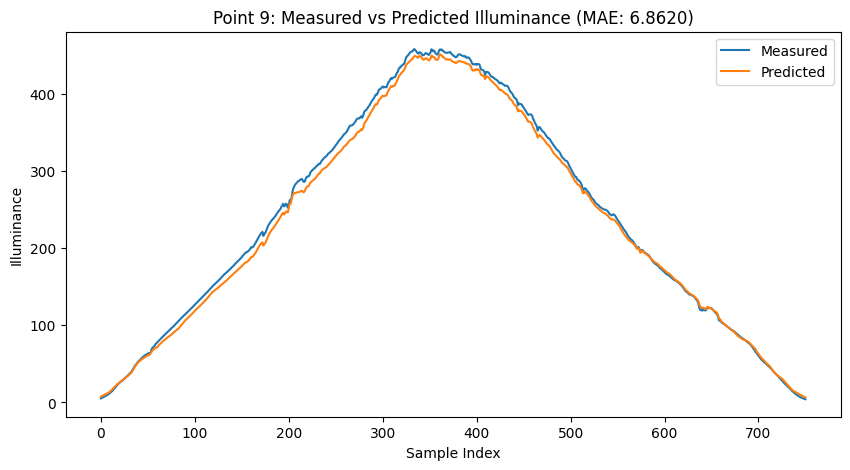

결과 엑셀 파일로 저장 완료


In [11]:
# 테스트용 데이터로 모델 검증(2024.04.07 맑은 날 데이터)
df_test = pd.read_excel('data/test_data_20240407.xlsx')
df_test['distance'] = calculate_distance(df_test['x'], df_test['y'])

# Evaluate the model for each point and save results to Excel
writer = pd.ExcelWriter('actual_predicted_results_per_point.xlsx', engine='openpyxl')

# Loop through each point (assuming 'point' column exists in df_test)
for point in df_test['point'].unique():
    df_point = df_test[df_test['point'] == point]
    X_point = df_point[['azimuth', 'elevation', 'x', 'y', 'new_illum_11', 'distance']].values
    y_point = df_point['illum'].values

    # Convert to PyTorch tensors for prediction
    X_point_tensor = torch.tensor(X_point, dtype=torch.float32)
    y_point_tensor = torch.tensor(y_point, dtype=torch.float32).unsqueeze(1)
    
    # Predict
    model.eval()
    with torch.no_grad():
        predictions = model(X_point_tensor).numpy()
        actuals = y_point_tensor.numpy()
    
    # Calculate MAE for the point
    mae = np.mean(np.abs(predictions - actuals))
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(actuals, label='Measured')
    plt.plot(predictions, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Illuminance')
    plt.title(f'Point {point}: Measured vs Predicted Illuminance (MAE: {mae:.4f})')
    plt.legend()
    plt.show()

    # Save results to Excel
    df_results = pd.DataFrame({
        'datetime': df_point['datetime'],
        'actual': actuals.flatten(), 
        'predicted': predictions.flatten()
    })
    df_results.to_excel(writer, sheet_name=f'Point_{point}', index=False)

writer.close()
print("결과 엑셀 파일로 저장 완료")
